In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import sys
#reload(sys)
#sys.setdefaultencoding('utf-8')


# Any results you write to the current directory are saved as output.

['google-word-embedding', 'lyrics-generation', 'glove6b']


* In this part, I build a neural network with LSTM and word embeddings were learned while fitting the neural network.

In [2]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


In [3]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 30  # Number of epochs we usually start to train with
BATCH_SIZE = 1  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [4]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
#Data Preparation

In [5]:
BASE_DIR = '../input/'
df = pd.read_csv('../input/lyrics-generation/train_lyrics_1000.csv')
df1 =pd.read_csv('../input/lyrics-generation/valid_lyrics_200.csv')
EMBEDDING_FILE = '../input/glove6b/glove.6B.100d.txt'
print(df1.head())
#print(df1['lyrics'][0])

df.head()

                    file  ...     mood
0  TRAFAIB128F426E636.h5  ...    happy
1  TRAFAJC128E078888B.h5  ...      sad
2  TRAFBBP128F92F6CC9.h5  ...    happy
3  TRAFBVU128F426B3F6.h5  ...      sad
4  TRAFEEO12903CFEC87.h5  ...      sad

[5 rows x 6 columns]


,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


In [6]:
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load
import numpy as np

X_train = df['lyrics'].values 

y_train = df['mood'].values

X_valid = df1['lyrics'].values 

y_valid = df1['mood'].values

df = df[['lyrics', 'mood']]
df.lyrics = df.lyrics.apply(remove_stopwords).apply(remove_mentions)

print('before embeding training data: %s ...' %y_train[:5])
print('before encoding validation data: %s ...' %y_valid[:5])


print('after encoding train data: %s ...' %y_train[:5])
print('after encoding validation data: %s ...' %y_valid[:5])

before embeding training data: ['sad' 'happy' 'sad' 'happy' 'sad'] ...
before encoding validation data: ['happy' 'sad' 'happy' 'sad' 'sad'] ...
after encoding train data: ['sad' 'happy' 'sad' 'happy' 'sad'] ...
after encoding validation data: ['happy' 'sad' 'happy' 'sad' 'sad'] ...


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.lyrics, df.mood, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 900
# Test data samples: 100



Train-Test split

In [8]:
### Converting words to numbers


In [9]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [10]:
print(X_train[0])
print( len(X_train[0]))
print(X_train_seq[0])
print(len(X_train_seq[0]))

Verse One: Alright might Have little glare stared ya ho But know like She stared right back My niggas warnin comin react like mack act cool Just test cause ain't no jester suggest friend outtie Cause want make pals get rowdy And doubt friendship But lips touch go crazy clutch Sorta like schitzo forgets bros pals gals mean fiend Strange things denim no matter who's em Grab flooze I'm traffic Don't laugh might girl I'm talkin mean Chorus: Repeat 2X It ain't fault girl got caught It ain't fault girl got caught (I mean to) Verse Two: Another incident went Way beyond done John stopped drawers dropped But ain't no quittin Really care who's girl hittin admit skinz ain't reason lose friends But know, sorry Accept apologies live Are goin hold grudges well oh fudge Its new year fear Ya actions ya actin shy mean ya need smackin That hoe Instead tryin front ya know Thats exactly I'm goin ya know run game ya know Cause entertainin meant blame women For makin Ak seem When call screen mean Chorus Ver

Creating word sequences of equal length
Before we can compute the word embeddings, we need to make sure the sequences are of equal length. In the example below, we truncate sequences to length MAX_LEN, or pad them with zeroes to achieve this. First, we'll have a look at the length of the (cleaned) lyrics.

In [11]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    900.000000
mean     148.543333
std       95.810211
min        1.000000
25%       89.000000
50%      123.000000
75%      169.000000
max      685.000000
Name: lyrics, dtype: float64

Based on the figures above we will set MAX_LEN to 24. So this means we will not be truncating any words, only pad with zeros. This is to avoid to lose information as the tweets are rather short.

In [12]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [13]:
X_train_seq_trunc[10]  

array([ 100,   11,   56,   42,   46,   67,  100,  897, 1008,  739,   42,
         46,   67,  100,  897, 1008,  739,  310,   49,   80, 3042,  119,
         80, 3042], dtype=int32)

Converting the target classes to numbers

In [14]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print(y_train_le)

[0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1
 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0
 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0
 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0
 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1
 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0
 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0
 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0
 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1
 1 1 1 0 1 1 1 1 0 1 0 1 

In [15]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)
print('Shape of validation set:',X_train_emb.shape)
print('Shape of validation set:',y_valid_emb.shape)
print('Shape of validation set:',y_train_emb.shape)

Shape of validation set: (90, 24)
Shape of validation set: (810, 24)
Shape of validation set: (90, 2)
Shape of validation set: (810, 2)


In [16]:
y_valid_emb[0]

array([0., 1.], dtype=float32)

In [17]:
#sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve,f1_score
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#load package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from math import sqrt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [18]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model. RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
   #tree.ExtraTreeClassifier(),
    
    ]

Modeling
Training word embeddings
Keras provides an Embedding layer which helps us to train specific word embeddings based on our training data. It will convert the words in our vocabulary to multi-dimensional vectors.

In [19]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 386       
Total params: 80,386
Trainable params: 80,386
Non-trainable params: 0
_________________________________________________________________


In [20]:
emb_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
emb_model.fit(X_train_emb, y_train_emb,
          epochs=20,
          batch_size=128)
score = emb_model.evaluate(X_valid_emb, y_valid_emb, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
810/810 [==============================] - 1s 625us/step - loss: 0.6926 - acc: 0.5000
Epoch 2/20
810/810 [==============================] - 0s 17us/step - loss: 0.6759 - acc: 0.7272
Epoch 3/20
810/810 [==============================] - 0s 18us/step - loss: 0.6631 - acc: 0.8012
Epoch 4/20
810/810 [==============================] - 0s 17us/step - loss: 0.6497 - acc: 0.8383
Epoch 5/20
810/810 [==============================] - 0s 17us/step - loss: 0.6352 - acc: 0.8728
Epoch 6/20
810/810 [==============================] - 0s 17us/step - loss: 0.6195 - acc: 0.9111
Epoch 7/20
810/810 [==============================] - 0s 16us/step - loss: 0.6024 - acc: 0.9407
Epoch 8/20
810/810 [==============================] - 0s 16us/step - loss: 0.5843 - acc: 0.9580
Epoch 9/20
810/810 [==============================] - 0s 17us/step - loss: 0.5652 - acc: 0.9630
Epoch 10/20
810/810 [==============================] - 0s 16us/step - loss: 0.5451 - ac

In [22]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history.history['acc'][-1]

0.9975308641975309

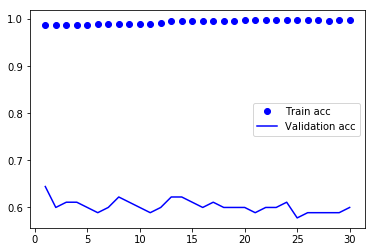

In [23]:
eval_metric(emb_history, 'acc')

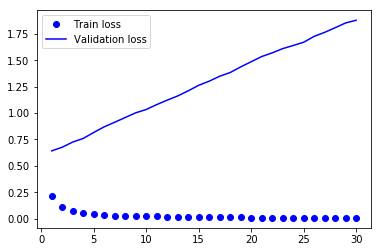

In [24]:
eval_metric(emb_history, 'loss')

In [25]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 60)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

100/100 [==============================] - 0s 84us/step
/n
Test accuracy of word embeddings model: 51.00%


This test result is quite ok, but still not better than the other deep learning model with Dropout layers, nor the LogisticRegression. Let's see if we can improve with pretrained word embeddings.

Using pre-trained word embeddings
Because the training data is not so big, the model might not be able to learn good embeddings for the sentiment analysis. Luckily we can load pre-trained word embeddings built on a much larger training data.

In [26]:
# load the whole embedding into memory
emb_dict = dict()
f = open("../input/glove6b/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(emb_dict))

Loaded 400000 word vectors.


let's see an example

In [27]:
airline_words = ['airplane', 'airline', 'flight', 'luggage']
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))


Found the word airplane in the dictionary
Found the word airline in the dictionary
Found the word flight in the dictionary
Found the word luggage in the dictionary


To feed this into an Embedding layer, we need to build a matrix containing the words in the lyrics and their representative word embedding. So this matrix will be of shape (NB_WORDS, GLOVE_DIM)

In [28]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [29]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(2, activation='softmax'))
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4802      
Total params: 1,004,802
Trainable params: 1,004,802
Non-trainable params: 0
_________________________________________________________________


With the set_weights method we load the pre-trained embeddings in the Embedding layer (here layer 0). By setting the trainable attribute to False, we make sure not to change the pre-trained embeddings.

In [30]:
glove_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [32]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
glove_history.history['acc'][-1]

0.9975308641975309

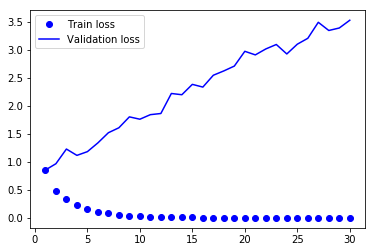

In [33]:
eval_metric(glove_history, 'loss')

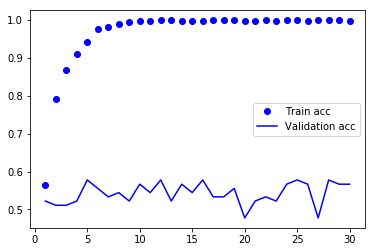

In [34]:
eval_metric(glove_history, 'acc')

In [35]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))


100/100 [==============================] - 0s 48us/step
/n
Test accuracy of word glove model: 43.00%


The model overfits fast. Moreover the test accuracy is lower compared to the embeddings trained on the training data.

As a final exercise, let's see what results we get when we train the embeddings with the same number of dimensions as the GloVe data.

TRAIN MODEL WITH MORE DIMENSION

In [36]:
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(2, activation='softmax'))
emb_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4802      
Total params: 1,004,802
Trainable params: 1,004,802
Non-trainable params: 0
_________________________________________________________________


In [37]:
emb_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
emb_history2 = deep_model(emb_model2, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history2.history['acc'][-1]

0.9975308641975309

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


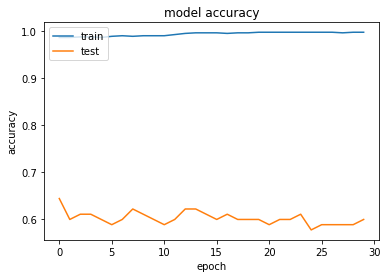

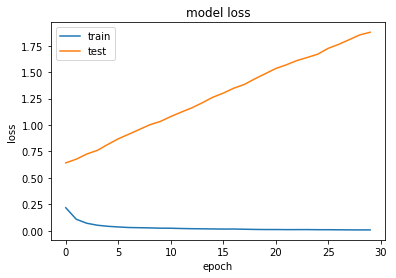

In [39]:
print(emb_history.history.keys())
# summarize history for accuracy
plt.plot(emb_history.history['acc'])
plt.plot(emb_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(emb_history.history['loss'])
plt.plot(emb_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

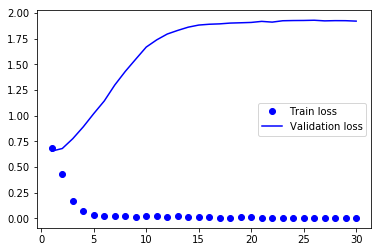

In [40]:
eval_metric(emb_history2, 'loss')

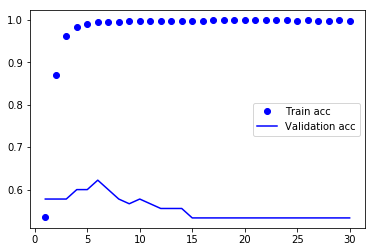

In [41]:
eval_metric(emb_history2, 'acc')

In [42]:
emb_results2 = test_model(emb_model2, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word embedding model 2: {0:.2f}%'.format(emb_results2[1]*100))

100/100 [==============================] - 0s 52us/step
/n
Test accuracy of word embedding model 2: 57.00%
